In [20]:
# Activate project enviroment 
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\Herbert\Documents\GitHub\AMO_Project`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\workdir\usr\share\julia\stdlib\v1.8\Pkg\src\API.jl:1535


In [21]:
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots
using Clustering
using Distances
using LinearAlgebra

## Scenario generation

For the generation of scenarios we consider the Monte Carlo approach. Thus, in the first step, we fit the Weibull distributions to the given data. (Each hour of each wind farm has it's own independent distribution) and then randomly generate scenarios out of these distributions. To get actual wind energy values from the normalized scenarios, we consider the given energy forcast for each wind farm (see table) as the mean of the energy production level over all 43 hours. (i.e. if the mean value of the scenarios would be 0.5 and the energy forcast is 100, we get a factor of 200)

To generate random scenarios, we first fit weibull distributions to every hour in every zone of the dataset. We treat every wind farm as one dimension, as they are independent sources of uncertainty. Thus, in every timestep we form 4 distributions (for each zone).

In [22]:
# read in wind data for the aggregated zones 1-4 corresponding to the wind farms 1-4 and remove fist coloum as it contains redundant index.
scenarios = [CSV.read("./data/aggr_zone1.csv", DataFrame),CSV.read("./data/aggr_zone2.csv", DataFrame),CSV.read("./data/aggr_zone3.csv", DataFrame),CSV.read("./data/aggr_zone4.csv", DataFrame)]
c = 1
for i in scenarios
    scenarios[c]= i[:,2:end]
    c = c+1
end

In [23]:
# scale the data to fit our model (set the predicted output to the mean of all scenarios)

forecast = [120.54, 115.52, 53.34, 38.16]

function getMean(df)
    return mean(mean.(eachrow(df)))
end

counter = 1
for s in scenarios
    factor = forecast[counter]/getMean(s)
    transform!(s,x -> x .* factor)
    counter = counter + 1
end

In [24]:
# Fit distributions to the given data. 
dist = [[fit_mle(Weibull,Array(scenarios[i][k,:])) for i in 1:4] for k in 1:43]
# to access distribution of zone 2, hour 3: dist[3][2]
dist[3][2]

Weibull{Float64}(α=9.553051628617052, θ=165.86692692294247)

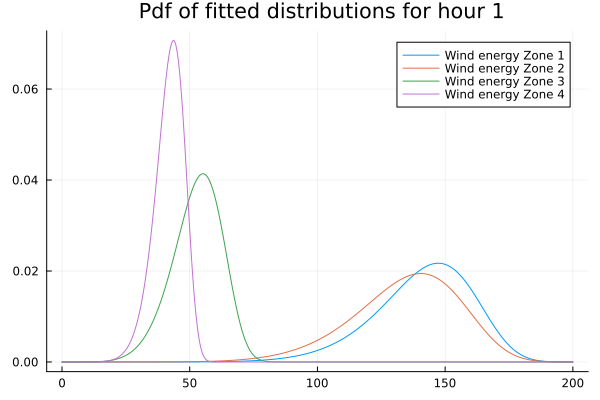

In [25]:
#Plot pdf of Estimations - Exemplary first hour for all 4 zones
x = 0.0:0.01:200
plot(x,pdf.(dist[1][1],x),label="Wind energy Zone 1",bandwidth= 0.01,title=" Pdf of fitted distributions for hour 1")
plot!(x,pdf.(dist[1][2],x),label="Wind energy Zone 2",bandwidth= 0.01)
plot!(x,pdf.(dist[1][3],x),label="Wind energy Zone 3",bandwidth= 0.01)
plot!(x,pdf.(dist[1][4],x),label="Wind energy Zone 4",bandwidth= 0.01)

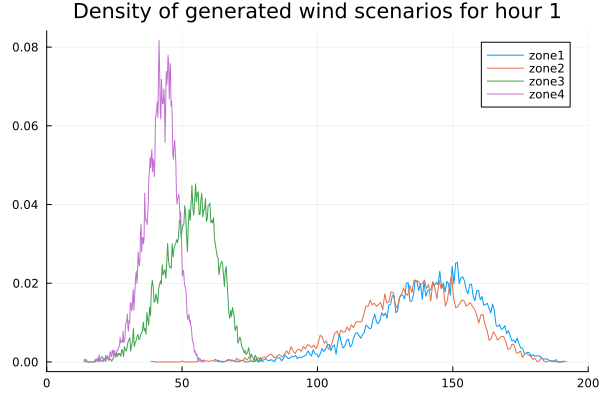

In [26]:
# Generate new scenarios from the distributions (1000 for each hour)
S=5000
new_scenarios = [hcat(rand.(dist[i], S)...)' for i in 1:43]

density(new_scenarios[1][1,:],bandwidth= 0.1,title="Density of generated wind scenarios for hour 1",label = "zone1",xlim = (0,200))
density!(new_scenarios[1][2,:],bandwidth= 0.1,label ="zone2",xlim = (0,200))
density!(new_scenarios[1][3,:],bandwidth= 0.1,label ="zone3",xlim = (0,200))
density!(new_scenarios[1][4,:],bandwidth= 0.1,label ="zone4",xlim = (0,200))


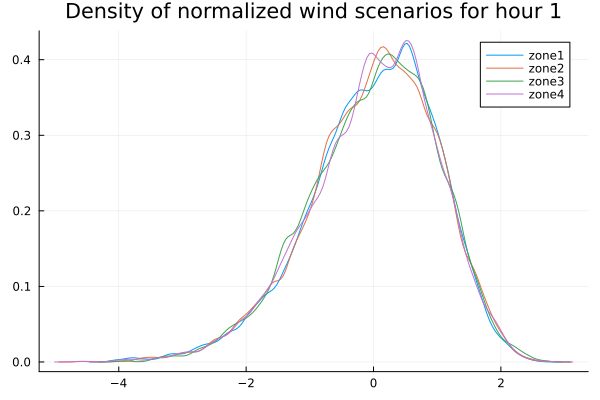

In [27]:
## Scenario Reduction via KMeans
# Normalize scenarios
μs = [mean.(eachrow(new_scenarios[i])) for i in 1:43]
stds = [std.(eachrow(new_scenarios[i])) for i in 1:43]
normalized_scenarios = [(new_scenarios[i] .- μs[i]) ./ stds[i] for i in 1:43]

density(normalized_scenarios[1][1,:],bandwidth= 0.1,title="Density of normalized wind scenarios for hour 1",label = "zone1")
density!(normalized_scenarios[1][2,:],bandwidth= 0.1,label ="zone2")
density!(normalized_scenarios[1][3,:],bandwidth= 0.1,label ="zone3")
density!(normalized_scenarios[1][4,:],bandwidth= 0.1,label ="zone4")

In [28]:
# apply kmeans on every hour with 5 cluster centers.
km = [kmeans(normalized_scenarios[i],5) for i in 1:43]

43-element Vector{KmeansResult{Matrix{Float64}, Float64, Int64}}:
 KmeansResult{Matrix{Float64}, Float64, Int64}([-1.437976236861392 0.10762961814079759 … 0.5562218931302703 0.256187009828912; 0.21282639244964935 -1.4109132541080838 … 0.5155789854753708 0.31193156392435595; 0.2247085656312446 0.09337887744068488 … 0.6678548052666593 -1.326136822223912; 0.15507702230858528 0.2826227043307013 … 0.5134999880411418 0.28005810973883977], [2, 4, 1, 5, 5, 3, 4, 5, 2, 5  …  1, 4, 5, 3, 3, 4, 1, 4, 5, 4], [0.8888040522946805, 0.5937546157274505, 1.3694675765869722, 2.9359928519086704, 1.3211653428183885, 1.241292840909714, 0.957311401864517, 7.244537997296528, 0.7789361643071322, 1.8466192336870018  …  2.799659976329955, 1.3105086961175718, 0.9823213018760395, 2.2513175403840013, 2.610306653389836, 2.0932289723227537, 4.445090143121501, 0.7642981954879875, 4.50290988028434, 3.6169465793673816], [912, 913, 939, 1283, 953], [912, 913, 939, 1283, 953], 10563.730481792894, 26, true)
 KmeansResult{M

In [29]:
# get centers (= reduced scenarios) and re-scale them
centers = [km[i].centers .* stds[i] .+ μs[i] for i in 1:43]
print(centers[1][1,:])

[113.4578361798409, 143.5022516084406, 146.69700049474133, 152.2222578275069, 146.38999946241117]

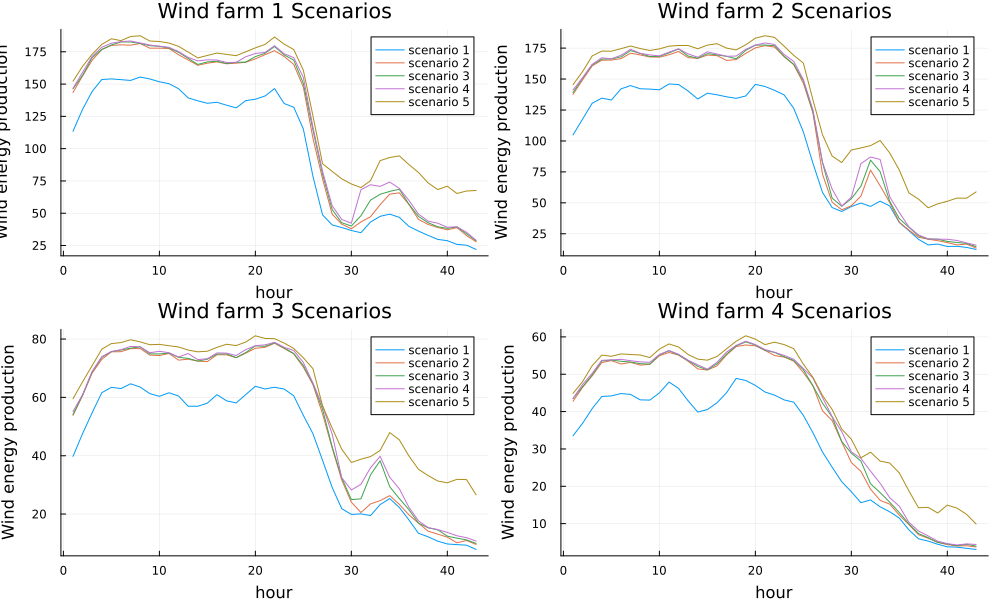

In [30]:
# Plot the generated scenarios.
# Sort scenarios for better visibility (This is possible since scenarios across different hours are completly independent, meaning the scenario index across hours is meaningless)
sorted_scenarios = deepcopy(centers)
for i in 1:43, k in 1:4
    sorted_scenarios[i][k,:] = sort!(Array(sorted_scenarios[i][k,:]))
end
function get_plot(k,data)
    a = plot(collect(1:43),[data[i][k,1] for i in 1:43] ,label = "scenario 1", xlabel = "hour", ylabel = "Wind energy production", title = "Wind farm " * string(k) * " Scenarios")
    plot!(collect(1:43),[data[i][k,2] for i in 1:43] ,label = "scenario 2", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k,3] for i in 1:43] ,label = "scenario 3", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k,4] for i in 1:43] ,label = "scenario 4", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k,5] for i in 1:43] ,label = "scenario 5", xlabel = "hour", ylabel = "Wind energy production")
    return a
end
plot(get_plot(1,sorted_scenarios),get_plot(2,sorted_scenarios),get_plot(3,sorted_scenarios),get_plot(4,sorted_scenarios),layout = (2,2),size = (1000,600))


In [48]:
# get probilities for every scenario
probs = DataFrame(Scen1 = Float64[],Scen2 =Float64[],Scen3=Float64[],Scen4=Float64[],Scen5=Float64[])
for i in 1:43
    push!(probs,Array(counts(km[i]) / S))
end
probs

Row,Scen1,Scen2,Scen3,Scen4,Scen5
,Float64,Float64,Float64,Float64,Float64
1,0.1824,0.1826,0.1878,0.2566,0.1906
2,0.2716,0.189,0.182,0.1758,0.1816
3,0.1858,0.168,0.2868,0.1778,0.1816
4,0.2902,0.1652,0.1884,0.1774,0.1788
5,0.174,0.2866,0.1688,0.1856,0.185
6,0.1764,0.1708,0.1876,0.2984,0.1668
7,0.2984,0.1782,0.1666,0.1812,0.1756
8,0.2984,0.1694,0.1888,0.1684,0.175
9,0.1806,0.2922,0.1724,0.1694,0.1854


In [42]:
# export reduced scenarios and probilities
for t in 1:43
    CSV.write("./data/scenarios_new/scenarios_hour$t.csv",  Tables.table(centers[t]))
end
CSV.write("./data/scenarios_new/probabilities.csv", probs)

"./data/scenarios_new/probabilities.csv"

## Scenario reduction via K-Medoids
We observe that some scenarios are very similar. Lets see what scenarios K-Medoids clustering yields.
K-Means uses the (arithmetic) average of a cluster's points, K-Medoids uses an actual data point with smallest intracluster distance (subject to any distance metric).

In [ ]:
#dist = [pairwise(Euclidean(), normalized_scenarios[i], dims=2) for i in 1:43]
kmed = [kmedoids(dist[i], 5) for i in 1:43]
centers2 = [[normalized_scenarios[k][:,i] for i in kmed[k].medoids] for k in 1:43] 
centers2 = [[centers2[i][k] .* stds[i] .+ μs[i] for k in 1:5] for i in 1:43]
sorted_scenarios2 = deepcopy(centers2)
sorted_scenarios2 = [[sort([sorted_scenarios2[k][s][w] for s in 1:5]) for w in 1:4] for k in 1:43]

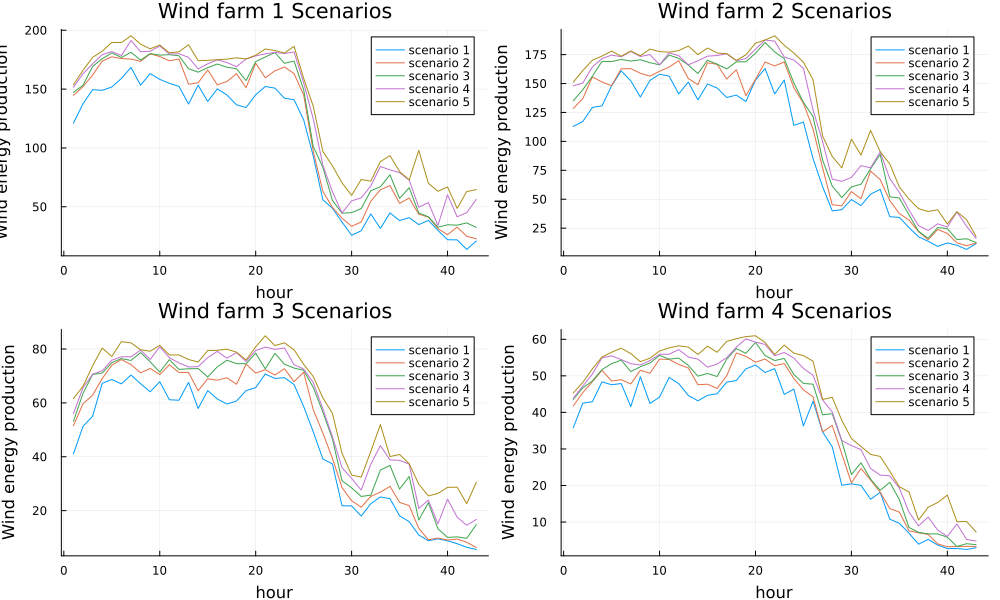

In [ ]:
function get_plot2(k,data)
    a = plot(collect(1:43),[data[i][k][1] for i in 1:43] ,label = "scenario 1", xlabel = "hour", ylabel = "Wind energy production", title = "Wind farm " * string(k) * " Scenarios")
    plot!(collect(1:43),[data[i][k][2] for i in 1:43] ,label = "scenario 2", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k][3] for i in 1:43] ,label = "scenario 3", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k][4] for i in 1:43] ,label = "scenario 4", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[data[i][k][5] for i in 1:43] ,label = "scenario 5", xlabel = "hour", ylabel = "Wind energy production")
    return a
end

sorted_scenarios2[1]
plot(get_plot2(1,sorted_scenarios2),get_plot2(2,sorted_scenarios2),get_plot2(3,sorted_scenarios2),get_plot2(4,sorted_scenarios2),layout = (2,2),size = (1000,600))